# STEFANO ANDREOTTI

## Packages

In [1]:
# Import necessary libraries
import networkx as nx # For graphs
import pickle # For data parsing
from networkx.algorithms.approximation import greedy_tsp # For approx TSP
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
from torch import Tensor
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import math
import warnings

import time
from timeit import default_timer as timer

## Helper functions

In [2]:
def tour_length(G, tour):
    """
    Compute the length of a tour. A tour is a list having elments 0 and -1 equal
    """
    assert tour[0] == tour[-1], "Not valid tour"
    estimated = 0
    n = G.number_of_nodes()
    for i in range(n):
        estimated += G[tour[i]][tour[i + 1]]['weight']
    return estimated

def greedy_algorithm(G):
    """
    Run the value of the greedy approximation algorithm on graph G
    """
    return tour_length(G, greedy_tsp(G, weight='weight'))

def random_tour(G, seed = 42):
    """
    Return the value of a random tour
    """
    np.random.seed(seed)
    n = G.number_of_nodes()
    tour = [0]
    for i in range(1, n):
        next_node = np.random.choice([j for j in range(n) if j not in tour])
        tour.append(next_node)
    tour.append(0)
    return tour_length(G, tour)

def transformer_tsp(G, model, DEVICE = 'cpu'):
    """
    Evaluate your (trained) model on G
    """
    # Set the model in evaluation mode

    model.eval()

    # Note: number of edges is constant ed equal to n(n-1)/2
    n = G.number_of_nodes()

    # Get node coordinates
    attr = nx.get_node_attributes(G, 'pos')
    x = []
    for i in range(n):
        x.append(torch.tensor(attr[i], dtype=torch.float32))

    # From list of tensors to tensor 2d
    x = torch.stack(x)

    tour = [0]
    y = torch.tensor(tour, dtype=torch.long)
    x = x.to(DEVICE).unsqueeze(0)
    y = y.to(DEVICE).unsqueeze(0)

    with torch.no_grad():

        _, tgt_mask, _, _ = create_mask(x, y, DEVICE)

        out = model(x, y, None, tgt_mask, None, None)

        # Loop until the tour is complete
        while len(tour) < n:
            _, idx = torch.topk(out, n, dim=2)
            for i in range(n):
                # Check if the node is already in the tour
                if idx[0, 0, i] not in tour:
                    tour.append(idx[0, 0, i])
                    break
            y = torch.tensor(tour)
            y = y.to(DEVICE).unsqueeze(0)

            tgt_seq_len = y.shape[1]

            tgt_mask = generate_square_subsequent_mask(tgt_seq_len)

            out = model(x, y, None, tgt_mask, None, None)
            # out = model(x, y)

    tour = [int(i) for i in tour] + [0] # Append the starting node (that is hard-coded to 0)

    return tour_length(G, tour)

def gap(G, model = None, model_GA = None, random_seed = 42, device = 'cpu'):
    """
    Compute the gap between the optimal solution on graph G and all the analyzed methods
    """
    # Optimal value (hard-coded in the graph)
    TSP = sum([G[i][j]['weight']*G[i][j]['tour'] for (i, j) in G.edges()]) # Optimal

    # Gaps dictionary
    gaps = {'greedy' : 0, 'random' : 0, 'transformer_tsp': 0, 'transformer_tsp_acc_grad': 0}
    gaps['greedy'] = 100* (greedy_algorithm(G) -  TSP) / TSP
    gaps['random'] = 100 * (random_tour(G, random_seed) - TSP) / TSP
    if model is not None:
        gaps['transformer_tsp'] = 100 * (transformer_tsp(G, model, DEVICE=device) - TSP) / TSP
    else:
        gaps['transformer_tsp'] = float('inf') # In case you just train with GA

    if model_GA is not None:
        gaps['transformer_tsp_acc_grad'] = 100 * (transformer_tsp(G, model_GA, DEVICE=device) - TSP) / TSP
    else:
        gaps['transformer_tsp_acc_grad'] = float('inf') # In case you just train without GA

    return gaps

## Dataset

In [3]:
# Load the dummy dataset for testing
parent_dir = "/content/drive/MyDrive/Deep/"
with open(parent_dir +'dummy_20_DLL_ass4.pkl', 'rb') as f:
    dummy_data = pickle.load(f)

# Get a single data item and explain its Python type
single_data_item = dummy_data[0]
print("Single data item:", single_data_item)
print("Type of single data item:", type(single_data_item))
print()

# Describe the edge attributes 'tour' and 'weight', and the node attribute 'pos'
graph, tour = single_data_item
print("Node attribute 'pos':", nx.get_node_attributes(graph, 'pos'))
print("Edge attribute 'weight':", nx.get_edge_attributes(graph, 'weight'))
print("Edge attribute 'tour':", nx.get_edge_attributes(graph, 'tour'))

Single data item: (<networkx.classes.graph.Graph object at 0x7c329ca3bf90>, [0, 3, 14, 2, 9, 6, 19, 13, 12, 16, 7, 18, 8, 17, 5, 11, 10, 15, 1, 4, 0])
Type of single data item: <class 'tuple'>

Node attribute 'pos': {0: (0.6049077053425551, 0.5748590937018008), 1: (0.38474987528197846, 0.9428085200806016), 2: (0.6102491981278754, 0.3707527129445174), 3: (0.5497610140601452, 0.514788385568776), 4: (0.5941533303116413, 0.6544475361385552), 5: (0.06187381797691738, 0.433195284467101), 6: (0.7475717305758963, 0.3950876312718402), 7: (0.6548530739834322, 0.06254140180263457), 8: (0.2210796367473482, 0.2142238067774731), 9: (0.6696714621150585, 0.4364218673039507), 10: (0.3206284506117195, 0.7885615893113229), 11: (0.37760295594024584, 0.4963855605324464), 12: (0.8300002368321365, 0.3489482457969727), 13: (0.9983722301898076, 0.2725163812162502), 14: (0.5306200040273271, 0.4146737532387711), 15: (0.2540580284004623, 0.8878378722372976), 16: (0.7024553839343133, 0.2586205516051998), 17: (0.11

In [4]:
# Load the real datasets for training, validation, and testing
with open(parent_dir +'train_20_DLL_ass4.pkl', 'rb') as f:
    train_data = pickle.load(f)

with open(parent_dir +'valid_20_DLL_ass4.pkl', 'rb') as f:
    valid_data = pickle.load(f)

with open(parent_dir +'test_20_DLL_ass4.pkl', 'rb') as f:
    test_data = pickle.load(f)

In [5]:
# Define the dataset class
class TSPDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        graph, tour = self.data[idx]
        pos = nx.get_node_attributes(graph, 'pos')
        X = torch.tensor([pos[i] for i in range(len(pos))], dtype=torch.float32)

        # Ensure the tour starts and ends with 0
        if tour[0] != 0 or tour[-1] != 0:
            tour = [0] + tour + [0]

        y = torch.tensor(tour, dtype=torch.long)  # y is Long for CrossEntropyLoss
        return X, y

In [6]:
# Create dataset objects for training, validation, and testing
train_dataset = TSPDataset(train_data)
valid_dataset = TSPDataset(valid_data)
test_dataset = TSPDataset(test_data)

# Set seed and device
torch.manual_seed(0)
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu')

# Create DataLoader objects for training, validation, and testing
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False)

## Model

In [7]:
class PositionalEncoding(nn.Module):
    def __init__(self,emb_size: int, dropout: float, maxlen: int = 5000):
        super(PositionalEncoding, self).__init__()

        pos_embedding = torch.zeros((maxlen, emb_size))
        pos = torch.arange(0, maxlen).reshape(maxlen, 1)
        den = torch.exp(- torch.arange(0, emb_size, 2)* math.log(10000) / emb_size)

        pos_embedding[:, 0::2] = torch.sin(pos * den)
        pos_embedding[:, 1::2] = torch.cos(pos * den)
        pos_embedding = pos_embedding.unsqueeze(-2)

        self.dropout = nn.Dropout(dropout)
        self.register_buffer('pos_embedding', pos_embedding)

    def forward(self, token_embedding: Tensor):
        return self.dropout(token_embedding + self.pos_embedding[:token_embedding.size(0), :])

class TSPTransformer(nn.Module):
    def __init__(self, n, num_encoder, num_decoder, de, dd, n_head, dropout, dim_feedforward=1024):
        super().__init__()
        # Encoder
        self.linear1 = nn.Linear(2, de)
        # Number of expected features in the input.
        encoder_layer = nn.TransformerEncoderLayer(d_model=de, nhead=n_head, dim_feedforward=dim_feedforward, batch_first=True)
        # Encoder layers
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_encoder)
        self.linear2 = nn.Linear(de, dd)

        # Decoder
        self.embedding = nn.Embedding(n, dd)
        self.posEncoding = PositionalEncoding(dd, dropout)
        decoder_layer = nn.TransformerDecoderLayer(d_model=dd, nhead=n_head, dim_feedforward=dim_feedforward, batch_first=True)
        self.decoder = nn.TransformerDecoder(decoder_layer, num_layers=num_decoder)
        self.ffnn = nn.Linear(dd, n)


    def forward(self, src: Tensor, trg: Tensor, src_mask: Tensor, tgt_mask: Tensor, src_padding_mask: Tensor, tgt_padding_mask: Tensor):
        # Encoding
        src = self.linear1(src)
        src = self.encoder(src, mask=src_mask, src_key_padding_mask=src_padding_mask)
        src = self.linear2(src)

        # Decoding
        trg = self.embedding(trg)
        trg = self.posEncoding(trg)
        output = self.decoder(trg, src, tgt_mask=tgt_mask, memory_mask=None,
                            tgt_key_padding_mask=tgt_padding_mask,
                            memory_key_padding_mask=src_padding_mask)
        output = self.ffnn(output)
        return output

In [8]:
def generate_square_subsequent_mask(sequence_length: int):
    mask = (torch.triu(torch.ones((sequence_length, sequence_length), device=DEVICE)) == 1).transpose(0, 1)
    mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
    return mask

def create_mask(src, tgt, DEVICE):
    src_seq_len = src.shape[1]
    tgt_seq_len = tgt.shape[1]

    tgt_mask = generate_square_subsequent_mask(tgt_seq_len)
    src_mask = torch.zeros((src_seq_len, src_seq_len), device=DEVICE).type(torch.bool)

    src_padding_mask = torch.zeros((src.shape[0], src_seq_len), device=DEVICE).bool()
    tgt_padding_mask = torch.zeros((tgt.shape[0], tgt_seq_len), device=DEVICE).bool()

    return src_mask, tgt_mask, src_padding_mask, tgt_padding_mask

In [9]:
n = 20 # Number of nodes
enc = 6 # Numver of encoder layers
dec = 6 # Number of decoder layers
de = 128 # Size of input coordinates
dd = 128 # Size of intermediate y
head = 8 # Number of attention heads in the multi-head attention
dropout = 0.3 # Dropout rate
dim_feedforward=1024 # Size of the feedforward neural network layer

TSPmodel = TSPTransformer(n, enc, dec, de, dd, head, dropout, dim_feedforward).to(DEVICE)

## Training

### Training WITHOUT gradient accumulation

In [10]:
# Function for training a single epoch
def train_epoch(model, optimizer, train_loader, loss_fn, DEVICE):
    model.train()
    losses = 0

    for src, tgt in train_loader:
        src = src.to(DEVICE)  # Node coordinates
        tgt = tgt.to(DEVICE)  # Tour indices

        tgt_input = tgt[:, :-1]  # Input to the decoder (shifted by one token)
        tgt_out = tgt[:, 1:]  # Target for loss computation (shifted by one token)

        optimizer.zero_grad()

        # Generate masks for attention
        src_mask, tgt_mask, src_padding_mask, tgt_padding_mask = create_mask(src, tgt_input, DEVICE)
        # Forward pass
        output = model(src, tgt_input, src_mask, tgt_mask, src_padding_mask, tgt_padding_mask)

        loss = loss_fn(output.reshape(-1, output.shape[-1]), tgt_out.reshape(-1))
        loss.backward()

        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        # Update weights
        optimizer.step()
        losses += loss.item()

    return losses / len(train_loader)

# Function for evaluation
def evaluate(model, valid_loader, loss_fn, DEVICE, num_heads):
    model.eval()
    losses = 0

    with torch.no_grad():
        for src, tgt in valid_loader:
            src = src.to(DEVICE)  # Node coordinates
            tgt = tgt.to(DEVICE)  # Tour indices

            tgt_input = tgt[:, :-1]  # Input to the decoder (shifted by one token)
            tgt_out = tgt[:, 1:]  # Target for loss computation (shifted by one token)

            # Generate masks for attention
            src_mask, tgt_mask, src_padding_mask, tgt_padding_mask = create_mask(src, tgt_input, DEVICE)
            # Forward pass
            output = model(src, tgt_input, src_mask, tgt_mask, src_padding_mask, tgt_padding_mask)

            loss = loss_fn(output.reshape(-1, output.shape[-1]), tgt_out.reshape(-1))
            losses += loss.item()

    avg_loss = losses / len(valid_loader)
    return avg_loss


warnings.filterwarnings("ignore")

# Hyperparameters
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(TSPmodel.parameters(), lr=0.0002, betas=(0.9, 0.98), eps=1e-9, weight_decay=0.01)

# Training configuration
n_epoch = 15
train_loss_list = []
val_loss_list = []
counter = 0
best_epoch = 0
print_every = 3
best_val_loss = float('inf')

start_tot_time = timer()

# Training loop
for epoch in range(n_epoch):
    # Train for one epoch
    train_loss = train_epoch(TSPmodel, optimizer, train_loader, loss_fn, DEVICE)

    # Evaluate on validation data
    val_loss = evaluate(TSPmodel, valid_loader, loss_fn, DEVICE, head)

    if best_val_loss < val_loss:
        counter += 1
        if counter == 5:
            print(f'Overfitting at epoch {epoch+1}')
            break
    else:
        counter = 0
        best_val_loss = val_loss
        best_epoch = epoch+1

    train_loss_list.append(train_loss)
    val_loss_list.append(val_loss)
    end_tot_time = timer() - start_tot_time

    if (epoch+1) % print_every == 0:
        print(f"Epoch: {epoch+1}: Train loss: {train_loss:.3f}, Val loss: {val_loss:.3f}")

    elif end_tot_time >= 600:
        print(f'Reached ten minutes of training at epoch {epoch+1}')
        break

print(f'Training time: {end_tot_time/60:.2f} minutes')
print(f"The best model is obtained at epoch {best_epoch} with a training loss of {train_loss_list[best_epoch-1]} and evaluation loss of {val_loss_list[best_epoch-1]}")

Epoch: 3: Train loss: 2.019, Val loss: 2.002
Epoch: 6: Train loss: 1.994, Val loss: 1.984
Epoch: 9: Train loss: 1.986, Val loss: 1.984
Reached ten minutes of training without overfitting at epoch 10
Training time: 11.88 minutes
The best model is obtained at epoch 10 with a training loss of 1.983850385238174 and evaluation loss of 1.9827826842665672


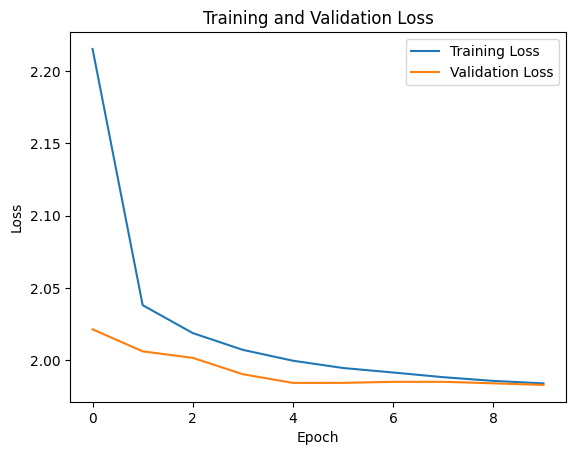

In [11]:
# Plot training and validation losses
plt.plot(train_loss_list, label='Training Loss')
plt.plot(val_loss_list, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.title('Training and Validation Loss')
plt.legend()
plt.show()

### Training WITH gradient accumulation

In [12]:
def train_epoch_acc(model, optimizer, trainloader, loss_fn, DEVICE, accum_iter=4):
    model.train()
    losses = 0
    optimizer.zero_grad()

    for batch_idx, (src, tgt) in enumerate(trainloader):
        src = src.to(DEVICE)  # Node coordinates
        tgt = tgt.to(DEVICE)  # Tour indices

        tgt_input = tgt[:, :-1]  # Input to the decoder (shifted by one token)
        tgt_out = tgt[:, 1:]  # Target for loss computation (shifted by one token)

        # Generate masks for attention
        src_mask, tgt_mask, src_padding_mask, tgt_padding_mask = create_mask(src, tgt_input, DEVICE)

        # Forward pass
        output = model(src, tgt_input, src_mask, tgt_mask, src_padding_mask, tgt_padding_mask)

        # Compute the loss divided by accum_iter for gradient accumulation
        loss = loss_fn(output.reshape(-1, output.shape[-1]), tgt_out.reshape(-1)) / accum_iter
        loss.backward()

        if (batch_idx + 1) % accum_iter == 0 or (batch_idx + 1 == len(trainloader)):
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            optimizer.zero_grad()

        # Accumulate the loss for logging
        losses += loss.item() * accum_iter

    return losses / len(trainloader)

modelACC = TSPTransformer(n, enc, dec, de, dd, head, dropout, dim_feedforward).to(DEVICE)

warnings.filterwarnings("ignore")

# Hyperparameters
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(modelACC.parameters(), lr=0.0002, betas=(0.9, 0.98), eps=1e-9, weight_decay=0.01)

# Training configuration
n_epoch = 15
train_loss_list = []
val_loss_list = []
counter = 0
best_epoch = 0
print_every = 3
best_val_loss = float('inf')

start_tot_time = timer()

# Training loop
for epoch in range(n_epoch):
    # Train for one epoch
    train_loss = train_epoch_acc(modelACC, optimizer, train_loader, loss_fn, DEVICE)

    # Evaluate
    val_loss = evaluate(modelACC, valid_loader, loss_fn, DEVICE, head)

    if best_val_loss < val_loss:
        counter += 1
        if counter == 5:
            print(f'Overfitting at epoch {epoch+1}')
            break
    else:
        counter = 0
        best_val_loss = val_loss
        best_epoch = epoch+1

    train_loss_list.append(train_loss)
    val_loss_list.append(val_loss)

    end_tot_time = timer() - start_tot_time

    if (epoch+1) % print_every == 0:
        print(f"Epoch: {epoch+1}: Train loss: {train_loss:.3f}, Val loss: {val_loss:.3f}")

    elif end_tot_time >= 600:
        print(f'Reached ten minutes of training at epoch {epoch+1}')
        break

print(f'Training time: {end_tot_time/60:.2f} minutes')
print(f"The best model is obtained at epoch {best_epoch} with a training loss of {train_loss_list[best_epoch-1]} and evaluation loss of {val_loss_list[best_epoch-1]}")

Epoch: 3: Train loss: 2.038, Val loss: 2.004
Epoch: 6: Train loss: 2.009, Val loss: 1.992
Epoch: 9: Train loss: 1.997, Val loss: 1.985
Reached ten minutes of training without overfitting at epoch 10
Training time: 10.86 minutes
The best model is obtained at epoch 9 with a training loss of 1.996690170549843 and evaluation loss of 1.9851356968283653


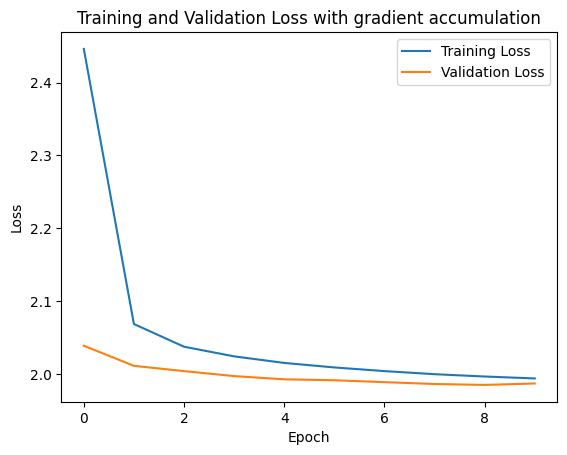

In [13]:
# Plot training and validation losses
plt.plot(train_loss_list, label='Training Loss')
plt.plot(val_loss_list, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.title('Training and Validation Loss with gradient accumulation')
plt.legend()
plt.show()

## Testing

In [14]:
# Get test data
graph, tour = test_data[0]
graph, tour

# Lists for gaps
gaps_random = []
gaps_greedy = []
gaps_model = []         # Standard
gaps_model_ga = []      # Gradient accumulation

for G, _ in test_data:
    # Compute gaps
    gaps = gap(G, TSPmodel, modelACC, device=DEVICE)

    # Store the gaps
    gaps_random.append(gaps['random'])
    gaps_greedy.append(gaps['greedy'])
    gaps_model.append(gaps['transformer_tsp'])
    gaps_model_ga.append(gaps['transformer_tsp_acc_grad'])

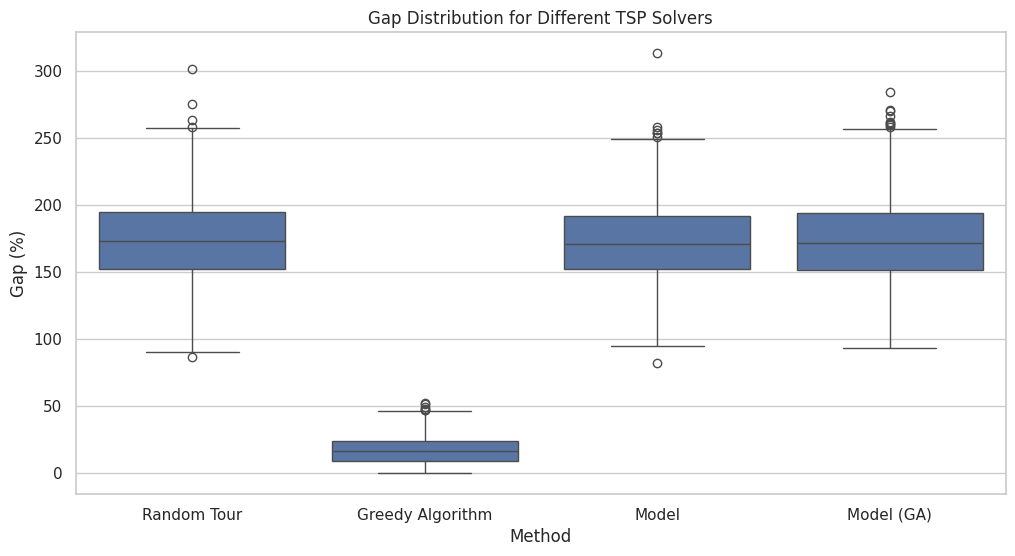

In [15]:
# Plotting the results
sns.set(style="whitegrid")
plt.figure(figsize=(12, 6))

data = pd.DataFrame({
    'Random Tour': gaps_random,
    'Greedy Algorithm': gaps_greedy,
    'Model': gaps_model,
    'Model (GA)': gaps_model_ga
})

# Melt the DataFrame for boxplot
data_melted = data.melt(var_name='Method', value_name='Gap')

# Create boxplots
sns.boxplot(x='Method', y='Gap', data=data_melted)

# Add plot title and labels
plt.title('Gap Distribution for Different TSP Solvers')
plt.xlabel('Method')
plt.ylabel('Gap (%)')

# Show the plot
plt.show()